In [ ]:
# SVM, 50 X 50

In [1]:
import os
import re
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
import random
import pickle
import cv2

from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
random.seed(1)
path = '/Users/clarysaaa/Desktop/LSE/LT ma429 machine learning/summative/Images'
folders = [folder for folder in os.listdir(path) if os.path.isdir(os.path.join(path, folder))]

In [3]:
data = []

In [4]:
# Define the target dimensions
target_width = 50
target_height = 50

# Iterate through the folders
for folder in folders:
    # Label as healthy or diseased
    if folder.endswith('healthy'):
        label = 1
    else:
        label = 0
    
    # Iterate through the images in the folder
    for image_name in os.listdir(os.path.join(path, folder)):
        # Get the image path
        image_path = os.path.join(path, folder, image_name)
        
        # Read the image using cv2
        img = cv2.imread(image_path)
        
        # Convert the image to grayscale
        bw_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Resize the image to the target dimensions
        resized_img = cv2.resize(bw_img, (target_width, target_height))
        
        # Convert image to pixel values
        pixel_values = np.array(resized_img)
        
        # Add image and label to the dataset
        data.append((pixel_values, label))

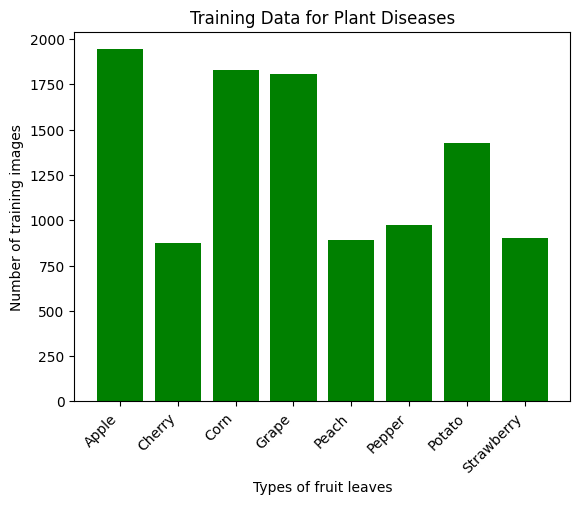

In [5]:
# Data exploration

# Define the types of fruits to search in the folder
target_words = ["Apple", "Cherry", "Corn", "Grape", "Peach", "Pepper", "Potato", "Strawberry"]

# Function to get subfolders containing a specific keyword in their names
def get_subfolders(directory, keyword):
    subfolders = [os.path.join(directory, d) for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    keyword_subfolders = [folder for folder in subfolders if keyword in folder]
    return keyword_subfolders

# Function to count images in a folder
def count_images_in_folder(directory):
    image_files = [f for f in os.listdir(directory) if re.match(r'.*\.(jpg|jpeg|png|gif)$', f, flags=re.IGNORECASE)]
    return len(image_files)

# Initialize a dictionary to store the number of images for each keyword
images = {}

# Iterate over each subfolder containing the keyword
for word in target_words:
    total_images = 0
    keyword_subfolders = get_subfolders(path, word)
    
    for folder in keyword_subfolders:
        num_images = count_images_in_folder(folder)
        total_images += num_images
    
    images[word] = total_images

# Create a bar chart
plt.bar(images.keys(), images.values(), color=(0/255, 128/255, 0/255))
plt.title("Training Data for Plant Diseases")
plt.xlabel("Types of fruit leaves")
plt.ylabel("Number of training images")
plt.xticks(rotation=45, ha='right')
plt.show()

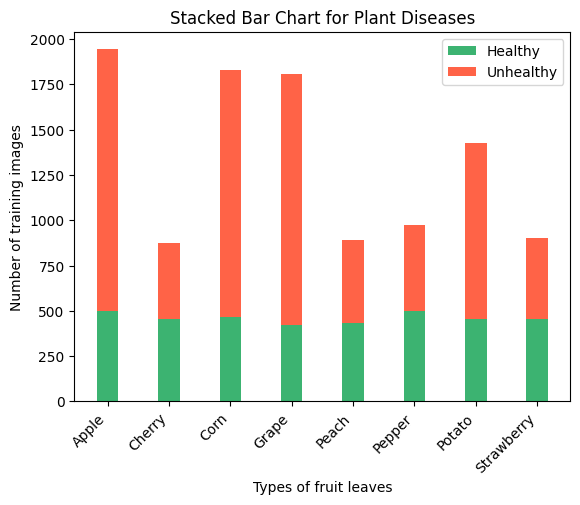

In [6]:
# Data exploration

# Function to get subfolders containing both keywords in their names
def get_subfolders_two(directory, keyword1, keyword2):
    subfolders = [os.path.join(directory, d) for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    keyword_subfolders = [folder for folder in subfolders if keyword1 in folder and keyword2 in folder]
    return keyword_subfolders

# Function to count images in a folder
def count_images_in_folder(directory):
    image_files = [f for f in os.listdir(directory) if re.match(r'.*\.(jpg|jpeg|png|gif)$', f, flags=re.IGNORECASE)]
    return len(image_files)

# Initialize dictionaries to store the number of images for healthy and unhealthy plants
images_healthy = {}
images_unhealthy = {}

# Iterate over each subfolder containing both keywords
for word in target_words:
    total_images_healthy = 0
    
    keyword_subfolders_healthy = get_subfolders_two(path, word, "healthy")
    
    for folder in keyword_subfolders_healthy:
        num_images = count_images_in_folder(folder)
        total_images_healthy += num_images
    
    images_healthy[word] = total_images_healthy

# Subtract healthy images from total images to get unhealthy images
images_unhealthy = {word: images[word] - images_healthy.get(word, 0) for word in target_words}

# Create a stacked bar chart
x = range(len(target_words))
width = 0.35

fig, ax = plt.subplots()

bars1 = ax.bar(x, images_healthy.values(), width, label='Healthy', color=(60/255, 179/255, 113/255))
bars2 = ax.bar(x, images_unhealthy.values(), width, label='Unhealthy', color=(255/255, 99/255, 71/255), bottom=list(images_healthy.values()))

ax.set_title("Stacked Bar Chart for Plant Diseases")
ax.set_xlabel("Types of fruit leaves")
ax.set_ylabel("Number of training images")
ax.set_xticks(x)
ax.set_xticklabels(target_words)
ax.legend()

plt.xticks(rotation=45, ha='right')
plt.show()

In [7]:
data = data[:10000]

In [8]:
# Shuffle the data
random.shuffle(data)

In [9]:
images = [pair[0] for pair in data]
labels = [pair[1] for pair in data]

In [10]:
# Define the proportions for train, validation, and test sets
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

In [11]:
# Calculate the number of samples for each set
num_samples = len(data)
num_train = int(train_ratio * num_samples)
num_val = int(val_ratio * num_samples)
num_test = num_samples - num_train - num_val

In [12]:
# Split the data
train_images = images[:num_train]
val_images = images[num_train:num_train + num_val]
test_images = images[num_train + num_val:]

# Split the data
train_labels = labels[:num_train]
val_labels = labels[num_train:num_train + num_val]
test_labels = labels[num_train + num_val:]

In [13]:
len(train_labels)

6000

In [14]:
def normalise_images(images):
    
    mean = np.mean(images, axis=0)
    print(mean)
    variance = np.var(images, axis=0)
    
    return mean, variance

In [15]:
mean, var = normalise_images(train_images)

[[128.6395     129.28366667 130.37716667 ... 130.15766667 129.269
  128.4015    ]
 [129.29633333 130.1035     130.81133333 ... 130.24033333 129.56633333
  128.85533333]
 [129.89166667 130.44683333 130.95433333 ... 130.33966667 129.66333333
  129.30033333]
 ...
 [127.756      128.05983333 128.13766667 ... 127.82233333 127.61466667
  127.3485    ]
 [127.28783333 127.517      127.648      ... 127.4415     127.583
  127.25333333]
 [126.45733333 127.27583333 127.6525     ... 127.18683333 126.93583333
  126.467     ]]


In [16]:
def apply_normalisation(images, mean, variance):
    
    images = (images - mean) / np.sqrt(variance)
    
    return images

In [17]:
# Normalize the data, Gaussian distribution
train_images = apply_normalisation(train_images, mean, var)
val_images = apply_normalisation(val_images, mean, var)
test_images = apply_normalisation(test_images, mean, var)

In [18]:
train_images

array([[[-2.13868672, -2.16766168, -2.20163951, ..., -2.19887879,
         -2.15908811, -2.12318156],
        [-2.15002923, -2.17975925, -2.2132444 , ..., -2.20568804,
         -2.16822214, -2.1445725 ],
        [-2.16540185, -2.1836747 , -2.21641823, ..., -2.20413163,
         -2.16828519, -2.14601466],
        ...,
        [-2.11185152, -2.12745298, -2.14104791, ..., -2.13248855,
         -2.12330127, -2.11221953],
        [-2.09819921, -2.11710465, -2.13447268, ..., -2.13261425,
         -2.11790862, -2.10149027],
        [-2.07878231, -2.10772145, -2.13051292, ..., -2.12384623,
         -2.11253625, -2.08647744]],

       [[-0.12700996, -0.52452415, -0.47919657, ..., -0.25607306,
         -0.25502724, -0.18852938],
        [ 0.4939332 ,  0.50088716,  0.84916026, ..., -0.15648987,
          0.074195  , -0.29717091],
        [ 0.30188094,  0.17665958,  0.28850001, ..., -0.17485073,
         -0.12814951, -0.12116459],
        ...,
        [-0.29351291, -0.34986618, -0.16938993, ...,  

In [19]:
img = train_images[2]

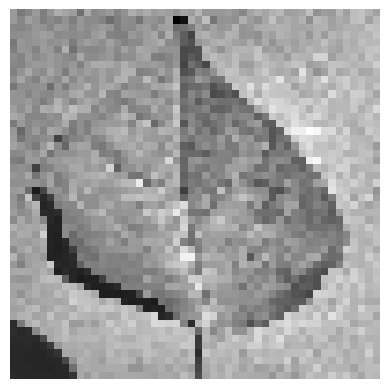

In [20]:
# Display the image
plt.imshow(img, cmap='gray')
plt.axis('off')  # Hide axis
plt.show()

In [21]:
# Convert lists to numpy arrays
train_images = np.array(train_images)
val_images = np.array(val_images)
test_images = np.array(test_images)

In [22]:
# Flatten the input images
train_images = train_images.reshape(len(train_images), -1)
val_images = val_images.reshape(len(val_images), -1)
test_images = test_images.reshape(len(test_images), -1)

In [23]:
# Define a range of C values to iterate over
C_values = [0.1, 1, 5, 10]

# Initialize a dictionary to store the accuracies for each C value
accuracy_dict_linear = {}

# Iterate over each C value
for C in C_values:
    # Create SVM classifier with linear kernel and specified C value
    clf_linear = svm.SVC(kernel='linear', C=C)
    
    # Fit the classifier to the training data
    clf_linear.fit(train_images, train_labels)
    
    # Save the model to a file using pickle
    model_filename = f"svm_model_linear_C_{C}.pickle"
    with open(model_filename, 'wb') as file:
        pickle.dump(clf_linear, file)
    
    # Make predictions on the testing data
    test_pred = clf_linear.predict(test_images)
    
    # Calculate the accuracy of the classifier
    accuracy = accuracy_score(test_labels, test_pred)
    
    # Store the accuracy in the dictionary
    accuracy_dict_linear[C] = accuracy

    print(f"Model with C={C} saved as {model_filename}")
    print(f"Accuracy for C={C}: {accuracy}")

# Print the accuracies for each C value
for C, accuracy in accuracy_dict_linear.items():
    print(f"Accuracy for C={C}: {accuracy}")

Model with C=0.1 saved as svm_model_linear_C_0.1.pickle
Accuracy for C=0.1: 0.6475
Model with C=1 saved as svm_model_linear_C_1.pickle
Accuracy for C=1: 0.639
Model with C=5 saved as svm_model_linear_C_5.pickle
Accuracy for C=5: 0.619
Model with C=10 saved as svm_model_linear_C_10.pickle
Accuracy for C=10: 0.605
Accuracy for C=0.1: 0.6475
Accuracy for C=1: 0.639
Accuracy for C=5: 0.619
Accuracy for C=10: 0.605


In [24]:
# Define a range of C, gamma, and degrees for polynomial kernel
C_values = [0.1, 1, 5, 10]
gamma_values = [0.01, 0.1, 1]
degrees = [2, 3, 4]

# Initialize dictionaries to store accuracies
accuracy_dict_rbf = {}
accuracy_dict_poly = {}

# Iterate over each C value for RBF kernel
for C in C_values:
    for gamma in gamma_values:
        # Create SVM classifier with RBF kernel, specified C and gamma
        clf_rbf = svm.SVC(kernel='rbf', C=C, gamma=gamma)
        clf_rbf.fit(train_images, train_labels)

        # Save the model to a file using pickle
        model_filename_rbf = f"svm_model_rbf_C_{C}_gamma_{gamma}.pickle"
        with open(model_filename_rbf, 'wb') as file:
            pickle.dump(clf_rbf, file)

        # Make predictions on the testing data and calculate accuracy
        test_pred_rbf = clf_rbf.predict(test_images)
        accuracy_rbf = accuracy_score(test_labels, test_pred_rbf)
        accuracy_dict_rbf[(C, gamma)] = accuracy_rbf

        print(f"RBF Model with C={C}, gamma={gamma} saved as {model_filename_rbf}")
        print(f"Accuracy for C={C}, gamma={gamma}: {accuracy_rbf}")

# Iterate over each C, gamma, and degree for polynomial kernel
for C in C_values:
    for gamma in gamma_values:
        for degree in degrees:
            # Create SVM classifier with polynomial kernel, specified C, gamma, and degree
            clf_poly = svm.SVC(kernel='poly', C=C, gamma=gamma, degree=degree)
            clf_poly.fit(train_images, train_labels)

            # Save the model to a file using pickle
            model_filename_poly = f"svm_model_poly_C_{C}_gamma_{gamma}_degree_{degree}.pickle"
            with open(model_filename_poly, 'wb') as file:
                pickle.dump(clf_poly, file)

            # Make predictions on the testing data and calculate accuracy
            test_pred_poly = clf_poly.predict(test_images)
            accuracy_poly = accuracy_score(test_labels, test_pred_poly)
            accuracy_dict_poly[(C, gamma, degree)] = accuracy_poly

            print(f"Poly Model with C={C}, gamma={gamma}, degree={degree} saved as {model_filename_poly}")
            print(f"Accuracy for C={C}, gamma={gamma}, degree={degree}: {accuracy_poly}")

# Optionally, print all accuracies
#print("RBF Kernel Accuracies:")
#for params, acc in accuracy_dict_rbf.items():
#    print(f"Accuracy for C={params[0]}, gamma={params[1]}: {acc}")

#print("Polynomial Kernel Accuracies:")
#for params, acc in accuracy_dict_poly.items():
#    print(f"Accuracy for C={params[0]}, gamma={params[1]}, degree={params[2]}: {acc}")

RBF Model with C=0.1, gamma=0.01 saved as svm_model_rbf_C_0.1_gamma_0.01.pickle
Accuracy for C=0.1, gamma=0.01: 0.6825
RBF Model with C=0.1, gamma=0.1 saved as svm_model_rbf_C_0.1_gamma_0.1.pickle
Accuracy for C=0.1, gamma=0.1: 0.6825
RBF Model with C=0.1, gamma=1 saved as svm_model_rbf_C_0.1_gamma_1.pickle
Accuracy for C=0.1, gamma=1: 0.6825
RBF Model with C=1, gamma=0.01 saved as svm_model_rbf_C_1_gamma_0.01.pickle
Accuracy for C=1, gamma=0.01: 0.6825
RBF Model with C=1, gamma=0.1 saved as svm_model_rbf_C_1_gamma_0.1.pickle
Accuracy for C=1, gamma=0.1: 0.6825
RBF Model with C=1, gamma=1 saved as svm_model_rbf_C_1_gamma_1.pickle
Accuracy for C=1, gamma=1: 0.6825
RBF Model with C=5, gamma=0.01 saved as svm_model_rbf_C_5_gamma_0.01.pickle
Accuracy for C=5, gamma=0.01: 0.6825
RBF Model with C=5, gamma=0.1 saved as svm_model_rbf_C_5_gamma_0.1.pickle
Accuracy for C=5, gamma=0.1: 0.6825
RBF Model with C=5, gamma=1 saved as svm_model_rbf_C_5_gamma_1.pickle
Accuracy for C=5, gamma=1: 0.6825
R

In [ ]:
# Load the saved model
#with open('model.pkl', 'rb') as file:
#    clf = pickle.load(file)

In [ ]:
#param_grid={'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['rbf','poly']}
#svc=svm.SVC(probability=True)
#print("The training of the model has started")
#model=GridSearchCV(svc,param_grid)
#model.fit(train_images,train_labels)
#print('Best parameters for SVM model')
#model.best_params_

In [ ]:
# Lists to store training and validation accuracies
train_accuracies = []
val_accuracies = []

In [ ]:
# Make predictions on validation data
val_labels_pred = clf_linear.predict(val_images)

In [ ]:
# Evaluate the model on validation data
val_accuracy = accuracy_score(val_labels, val_labels_pred)
print("Validation Accuracy:", val_accuracy)
print(classification_report(val_labels, val_labels_pred))

# Store initial accuracy
train_accuracies.append(clf_linear.score(train_images, train_labels))
val_accuracies.append(val_accuracy)

In [ ]:
# Make predictions on test data
test_labels_pred = clf.predict(test_images)

In [ ]:
# Evaluate the model on test data
test_accuracy = accuracy_score(test_labels, test_labels_pred)
print("Test Accuracy:", test_accuracy)
print(classification_report(test_labels, test_labels_pred))

# Plotting training and validation accuracies over epochs
epochs = range(1, 2)  # Assuming only one epoch
plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Initialize SVM classifier, poly

# Define a parameter grid for GridSearchCV
param_grid = {'degree': [2, 3, 4, 5]}  # Specify the degrees to try

# Initialize SVM classifier with polynomial kernel
clf_poly = svm.SVC(kernel='poly')

# Initialize GridSearchCV with the SVM classifier and parameter grid
grid_search = GridSearchCV(clf_poly, param_grid, cv=5, n_jobs=-1)

# Perform hyperparameter tuning (fitting)
grid_search.fit(train_images, train_labels)

# Get the best degree from the grid search results
best_degree = grid_search.best_params_['degree']
print("Best degree:", best_degree)

# Train the classifier with the best degree
clf_poly_best = svm.SVC(kernel='poly', degree=best_degree)
clf_poly_best.fit(train_images, train_labels)

# Save the model
joblib.dump(clf_poly_best, 'model_poly.pkl')